# **Capstone Project - HerbPlants**




## Import Library

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import random
import shutil
import pathlib
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image

## Dataset

### Load Dataset

In [3]:
!wget https://github.com/Salmanim20/indomedicinalplant/raw/main/Indonesia%20Medicinal%20Plant%20Dataset.zip

--2025-06-09 14:32:58--  https://github.com/Salmanim20/indomedicinalplant/raw/main/Indonesia%20Medicinal%20Plant%20Dataset.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Salmanim20/indomedicinalplant/main/Indonesia%20Medicinal%20Plant%20Dataset.zip [following]
--2025-06-09 14:32:59--  https://raw.githubusercontent.com/Salmanim20/indomedicinalplant/main/Indonesia%20Medicinal%20Plant%20Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94022454 (90M) [application/zip]
Saving to: ‘Indonesia Medicinal Plant Dataset.zip’

Indonesia Medicinal 100%[===================>]  89.67M   182MB/s 

In [4]:
!mkdir -p "dataset/Indonesia Medicinal Plant Dataset"
!unzip -q "Indonesia Medicinal Plant Dataset.zip" -d "dataset/Indonesia Medicinal Plant Dataset"

In [5]:
base_path = "dataset/Indonesia Medicinal Plant Dataset"

image_paths = []
labels = []

for label in os.listdir(base_path):
    label_folder = os.path.join(base_path, label)
    if os.path.isdir(label_folder):
        for file_name in os.listdir(label_folder):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_folder, file_name))
                labels.append(label)

In [6]:
df = pd.DataFrame({
    'image': image_paths,
    'label': labels
})

df.head()

image  \
0  dataset/Indonesia Medicinal Plant Dataset/Isot...   
1  dataset/Indonesia Medicinal Plant Dataset/Isot...   
2  dataset/Indonesia Medicinal Plant Dataset/Isot...   
3  dataset/Indonesia Medicinal Plant Dataset/Isot...   
4  dataset/Indonesia Medicinal Plant Dataset/Isot...   

                           label  
0  Isotoma Longiflora (Ki Tolod)  
1  Isotoma Longiflora (Ki Tolod)  
2  Isotoma Longiflora (Ki Tolod)  
3  Isotoma Longiflora (Ki Tolod)  
4  Isotoma Longiflora (Ki Tolod)

In [7]:
class_counts = df['label'].value_counts()
print(class_counts)

label
Isotoma Longiflora (Ki Tolod)      100
Ricinus Communis (Jarak)           100
Psidium Guajava (Jambu Biji)       100
Zingiber Officinale (Jahe)         100
Celosia Cristata (Jengger Ayam)    100
                                  ... 
Pyrus Communis (Pir)               100
Derris Elliptica (Tuba)            100
Pluchea Indica (Beluntas)          100
Centella Asiatica (Pegagan)        100
Syzygium Polyanthum (Salam)        100
Name: count, Length: 100, dtype: int64


In [8]:
df['label'].unique()

array(['Isotoma Longiflora (Ki Tolod)', 'Ricinus Communis (Jarak)',
       'Psidium Guajava (Jambu Biji)', 'Zingiber Officinale (Jahe)',
       'Celosia Cristata (Jengger Ayam)',
       'Desmodium Triquitrum (Daun Duduk)',
       'Pleomele Angustifolia (Suji)', 'Borreria Hispida (Gempur Batu)',
       'Canangium Odoratum (Kenanga)', 'Crinum Asiaticum (Bakung Putih)',
       'Pogostemon Cablin (Nilam)', 'Tinospora Cordifolia (Brotowali)',
       'Acorus Calamus (Dlingo)', 'Pandanus Amaryllifolius (Pandan)',
       'Rosmarinus Officinalis (Rosemary)',
       'Citrus Amblycarpa (Jeruk Limau)',
       'Cestrum Nocturnum (Sedap Malam)',
       'Hibiscus Rosa-sinensis (Kembang Sepatu)',
       'Curcuma Domestica (Kunyit)', 'Impatiens Balsamina (Pacar Air)',
       'Annona Muricata (Sirsak)', 'Cymbopogon Nardus (Serai)',
       'Ziziphus mauritiana Lam. (Bidara)',
       'Artocarpus Heterophyllus (Nangka Mini)',
       'Talinum Triangulare (Som Jawa)', 'Ocimum Basilicum (Kemangi)',
       'Di

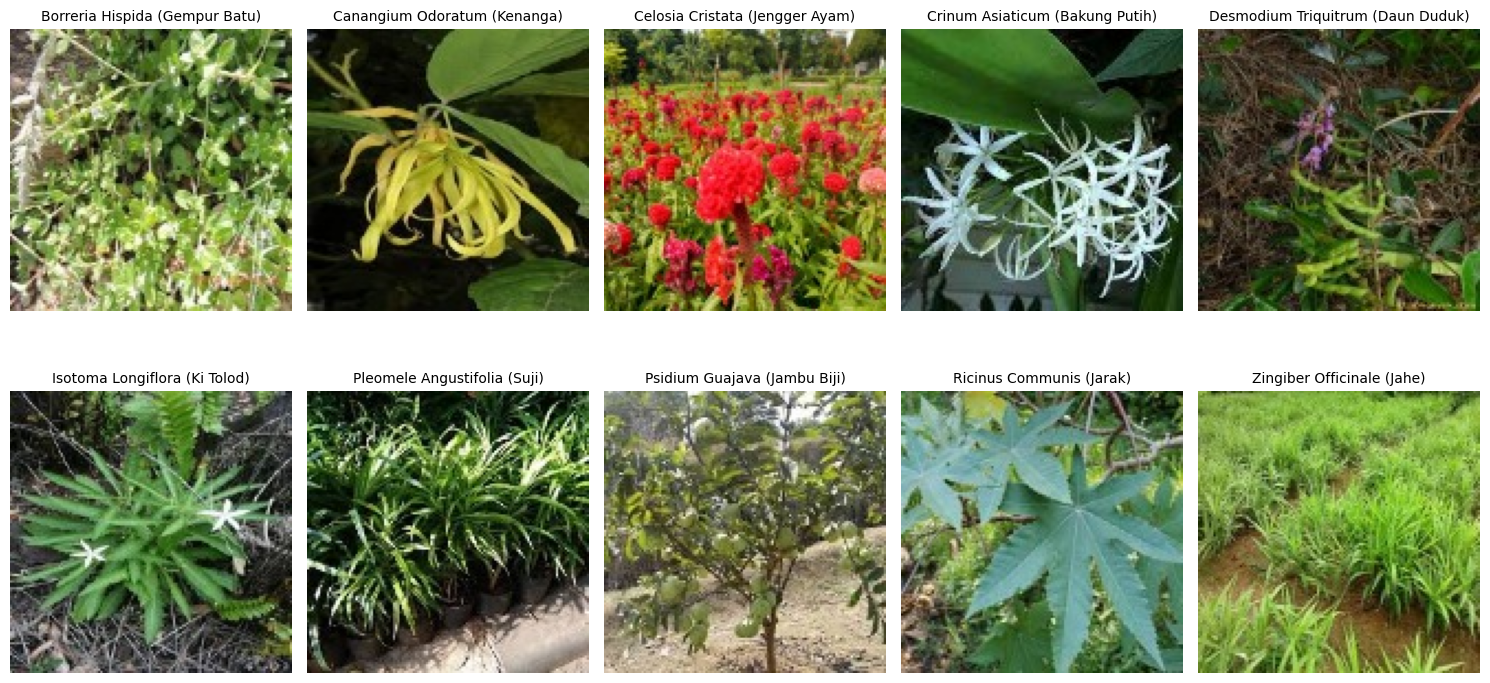

In [9]:
sampled_classes = df['label'].unique()[:10]
sampled_df = df[df['label'].isin(sampled_classes)].groupby('label').first().reset_index()

plt.figure(figsize=(15, 8))

for idx, row in sampled_df.iterrows():
    img = Image.open(row['image'])

    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(row['label'], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

### Split Dataset

In [10]:
train_df, val_test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
val_df, test_df = train_test_split(val_test_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [11]:
print('Data Training Shape    : ', len(train_df))
print('Data Validation Shape  : ', len(val_df))
print('Data Testing Shape     : ', len(test_df))

Data Training Shape    :  8000
Data Validation Shape  :  1000
Data Testing Shape     :  1000


### Data Augmentation

In [12]:
batch_size = 32
img_height = 224
img_width = 224

In [13]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_datagen = datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = datagen.flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8000 validated image filenames belonging to 100 classes.
Found 1000 validated image filenames belonging to 100 classes.
Found 1000 validated image filenames belonging to 100 classes.


In [14]:
data_augmentation = Sequential([
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal_and_vertical")
])

## Modelling

In [15]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_ex

In [17]:
pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [18]:
model = models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    data_augmentation,
    pre_trained_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [19]:
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = [
    EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)
]

In [21]:
history = model.fit(
    train_datagen,
    steps_per_epoch=len(train_datagen),
    epochs=100,
    validation_data=val_datagen,
    validation_steps=len(val_datagen),
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.0905 - loss: 4.3222 - val_accuracy: 0.2310 - val_loss: 3.2592 - learning_rate: 1.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.3946 - loss: 2.6251 - val_accuracy: 0.3670 - val_loss: 2.4860 - learning_rate: 1.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.5491 - loss: 1.8304 - val_accuracy: 0.4830 - val_loss: 2.0200 - learning_rate: 1.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.6378 - loss: 1.4505 - val_accuracy: 0.5190 - val_loss: 1.8353 - learning_rate: 1.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.6832 - loss: 1.2091 - val_accuracy: 0.6040 - val_loss: 1.5207 - learning_rate: 1.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.7412 - loss: 1.0065 - val_accuracy: 0.6360 - val_loss: 1.3589 - learning_rate: 1.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 7

In [22]:
import json

# Simpan class_indices ke file JSON
with open("class_indices.json", "w") as f:
    json.dump(train_datagen.class_indices, f)

# tampilkan hasil mapping
print("Label mapping disimpan sebagai class_indices.json:")
print(train_datagen.class_indices)

Label mapping disimpan sebagai class_indices.json:
{'Abelmoschus Esculentus (Okra)': 0, 'Acorus Calamus (Dlingo)': 1, 'Aloe Vera (Lidah Buaya)': 2, 'Alstonia Scholaris (Pulai)': 3, 'Amaranthus Spinosus (Bayam Duri)': 4, 'Andrographis Paniculata (Sambiloto)': 5, 'Annona Muricata (Sirsak)': 6, 'Annona Squamosa (Srikaya)': 7, 'Anredera Cordifolia (Binahong)': 8, 'Apium Graveolens (Seledri)': 9, 'Artocarpus Heterophyllus (Nangka Mini)': 10, 'Artocarpus Integer (Nangka Cempedak)': 11, 'Averrhoa Bilimbi (Belimbing Wuluh)': 12, 'Blumea Balsamifera (Sembung)': 13, 'Borreria Hispida (Gempur Batu)': 14, 'Caesalpinia Sappan L (Secang)': 15, 'Caladium Cicolor (Keladi)': 16, 'Calendula Officinalis (Marigold)': 17, 'Canangium Odoratum (Kenanga)': 18, 'Catharanthus Roseus (Tapak Dara)': 19, 'Celosia Cristata (Jengger Ayam)': 20, 'Centella Asiatica (Pegagan)': 21, 'Cestrum Nocturnum (Sedap Malam)': 22, 'Chrysopogon Zizanioides (Akar Wangi)': 23, 'Citrus Amblycarpa (Jeruk Limau)': 24, 'Clinalanthus Nut

## Evaluation

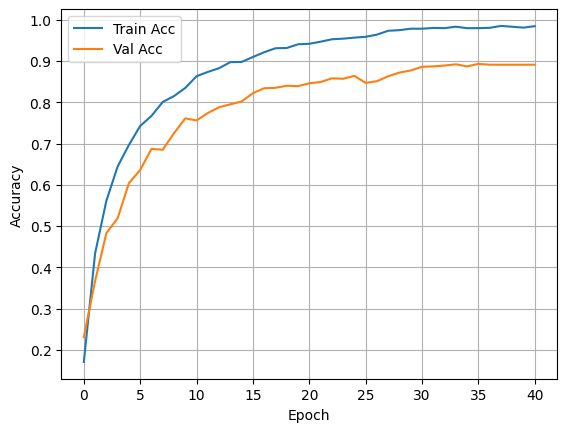

In [23]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=0)

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

Test Loss     : 0.5063
Test Accuracy : 0.8730


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


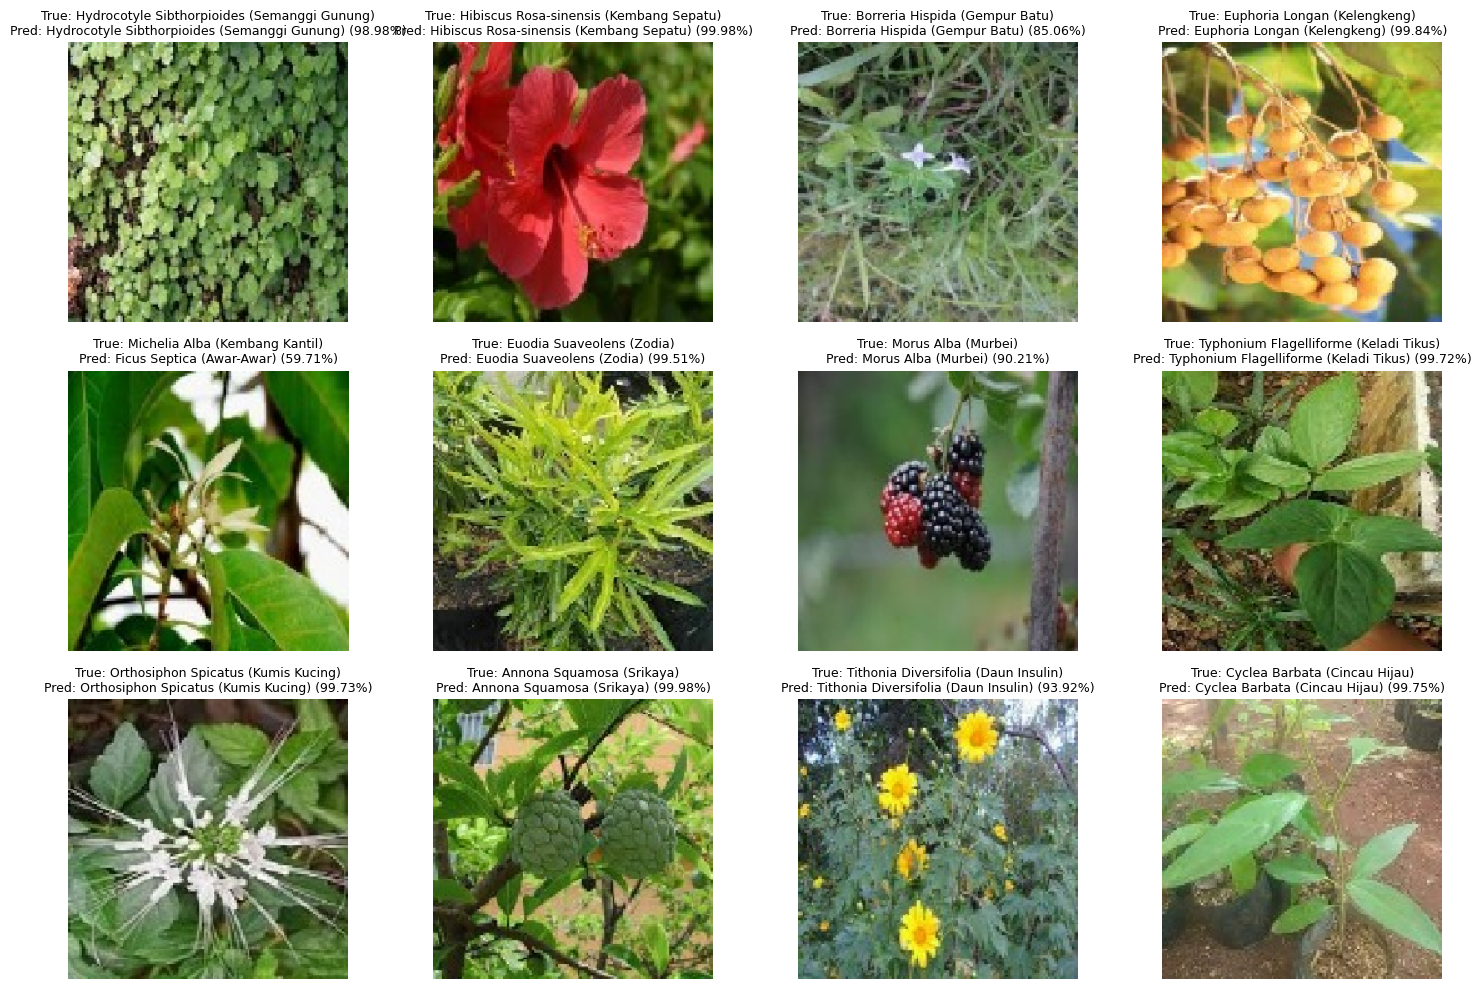

In [25]:
class_labels = list(test_datagen.class_indices.keys())

# Jumlah gambar yang ingin ditampilkan
num_images = 12
num_images_per_row = 4
num_rows = num_images // num_images_per_row

# Ambil satu batch dari test_datagen
images, labels = next(test_datagen)

# Lakukan prediksi
predictions = model.predict(images)

# Tampilkan hasil
plt.figure(figsize=(15, 10))
for i in range(num_images):
    predicted_index = np.argmax(predictions[i])
    predicted_class = class_labels[predicted_index]
    confidence = predictions[i][predicted_index] * 100  # jadi persen
    true_class = class_labels[np.argmax(labels[i])]

    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.2f}%)", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Inference

Saving images.jpeg to images.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


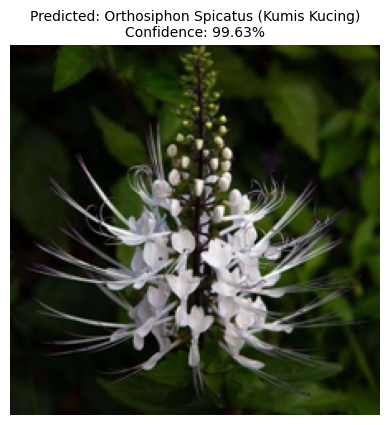

In [26]:
# Upload gambar
from google.colab import files
import io
uploaded = files.upload()

for file_binary in uploaded.values():
    img = Image.open(io.BytesIO(file_binary)).convert('RGB')
    img = img.resize((224, 224))

    # Preprocess
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    # Tampilkan
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=10)
    plt.axis('off')
    plt.show()

## Konversi Model

In [27]:
model.build((None, 224, 224, 3))
model.save('/content/Model/model.h5')

!tensorflowjs_converter --input_format=keras /content/Model/model.h5 /content/Model/tfjs_model

# Unduh file .h5
from google.colab import files
files.download('/content/Model/model.h5')

# Zip model TF.js dan download
!zip -r tfjs_model.zip /content/Model/tfjs_model
files.download('tfjs_model.zip')


2025-06-09 14:48:02.897930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749480482.918277    6007 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749480482.924575    6007 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Model/tfjs_model/ (stored 0%)
  adding: content/Model/tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: content/Model/tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: content/Model/tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: content/Model/tfjs_model/model.json (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
!pip freeze > requirements.txt

In [29]:
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>